In [1]:
from load_results import load_result_dataset
import pandas as pd
import numpy as np
pn1 = 'full_fine_tuning_50epochs_edge_paper_final2'
pn2 = 'full_fine_tuning_50epochs_paper_final2'
pn3 = 'none' #'full_fine_tuning_50epochs_budget'

final_data = load_result_dataset(pn1, pn2, pn3)
final_data = [{**d, 'ft_strategy': 'FFT (50 epochs)'} for d in final_data]

../results/none/CLIP-convnext_base_w-laion_aesthetic-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
HEY
../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion_aesthetic-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/none/CLIP-convnext_base_w-laion2B-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
HEY
../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion2B-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/none/deit_small_patch16_224.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
HEY
../results/full_fine_tuning_50epochs_paper_final2/deit_small_patch16_224.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/none/robust_resnet50_uc-merced-land-use-dataset_TRADES_v2.pkl
HEY
../results/full_fine_tuning_50epochs_paper_final2/robust_resnet50_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/none/vit_small_patch16_224.augreg_in21k_uc-merced-land-use-dataset_TRADES_v2.pkl
HEY
../results/full_fine_tuning_50

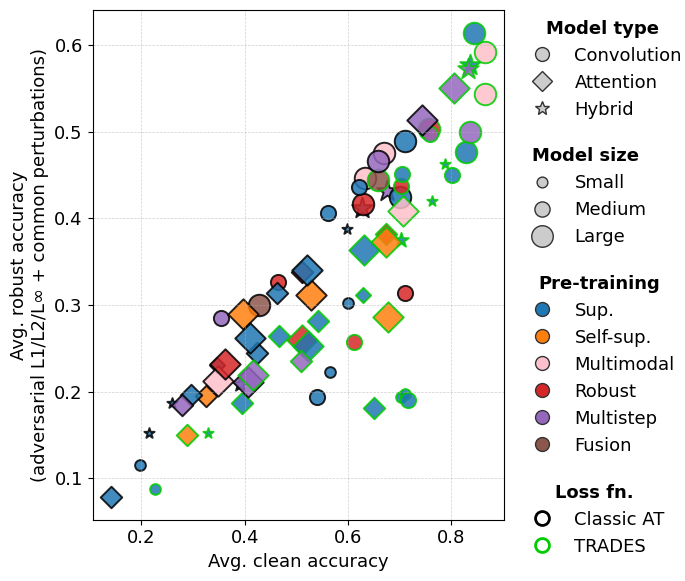

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math

import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15 })

pretty_color_labels = {
    'supervised': 'Sup.',
    'self-supervised': 'Self-sup.',
    'self-supervised (multimodal)': 'Multimodal',
    'supervised (robust)': 'Robust',
    'supervised (multistep)': 'Multistep',
    'fusion': 'Fusion',
    'fully convolutional': 'Convolution',
    'fully attention': 'Attention',
    'hybrid': 'Hybrid',
    'small': 'Small',
    'medium': 'Medium',
    'large': 'Large',
}

# ── 1) Load ─────────────────────────────────────────────────────────────
data = pd.DataFrame(final_data)

# ── 2) Aggregate per configuration ──────────────────────────────────────
group_cols = ['backbone_name', 'loss_function', 'ft_strategy']
agg = (
    data.groupby(group_cols)
        .agg({
            'clean_acc': 'mean',
            'L1_acc': 'mean',
            'L2_acc': 'mean',
            'Linf_acc': 'mean',
            'common_acc': 'mean',
            'model_type': 'first',
            'model_size': 'first',
            'pre_training_strategy': 'first'
        })
        .reset_index()
)

# Normalise the strategy strings so they match the colour keys
agg['pre_training_strategy'] = (
    agg['pre_training_strategy']
        .astype(str).str.strip().str.lower()
)

# ── 3) Robust average ───────────────────────────────────────────────────
agg['robust_avg'] = agg[['L1_acc', 'L2_acc', 'Linf_acc','common_acc' ]].mean(axis=1) 

# ── 4) Aesthetic mappings ───────────────────────────────────────────────
# marker_map = {'convolution': 'o', 'attention': 's', 'hybrid': '*'}
marker_map = {
    'fully convolutional'       : 'o',   # circle
    'fully attention': 'D',  # diamond
    'hybrid'    : '*'    # star
}

size_map   = {'small': 60, 'medium': 120, 'large': 240}

color_map = {
    'supervised'                    : '#1f77b4',
    'self-supervised'               : '#ff7f0e',
    'self-supervised (multimodal)'  : '#ffc0cb', #2ca02c
    'supervised (robust)'           : '#d62728',
    'supervised (multistep)'        : '#9467bd',
    'fusion'                        : '#8c564b'  # dark brownish, distinct from others
}


edge_map = {
    'Classic AT': '#000000',   # solid black
    'TRADES': '#00cc00'        # acid green
}

# edge_map   = {'CLASSIC_AT': '#000000', 'TRADES_v2': '#8c564b'}

# ── 5) Scatter plot ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 6))
# fig, ax = plt.subplots(figsize=(2.2, 2.0))  # ~33% of \textwidth, compact


for _, row in agg.iterrows():
    ax.scatter(
        row['clean_acc'],
        row['robust_avg'],
        marker   = marker_map.get(row['model_type'], 'o'),
        s        = size_map.get(row['model_size'], 80),
        color    = color_map.get(row['pre_training_strategy'], '#999999'),
        edgecolor= edge_map.get(row['loss_function'], '#333333'),
        linewidth=1.4,
        alpha    = 0.85
    )

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_xlabel('Avg. clean accuracy')
ax.set_ylabel('Avg. robust accuracy\n(adversarial L1/L2/L∞ + common perturbations)')

# Leave space on the right for the stacked legends
plt.tight_layout(rect=[0, 0, 0.78, 1])

# ── 6) Four non‑overlapping legends ─────────────────────────────────────
legend_kw = dict(frameon=True, framealpha=0.9, borderpad=0.6, fontsize=13)

#      (x,  y) are fractions of the axes bounding box (right side)
# Legend 1 — Model type
first = ax.legend(
    [Line2D([0], [0], marker=m, color='w', markerfacecolor='#cccccc',
            markeredgecolor='#333333', markersize=10) for m in marker_map.values()],
    [pretty_color_labels[k] for k in marker_map.keys()], title='Model type',
    loc='upper left', bbox_to_anchor=(1, 1.02), **legend_kw)
first.get_title().set_fontweight("bold")
first.get_frame().set_visible(False)

# Legend 2 — Model size
second = ax.legend(
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='#cccccc',
            markeredgecolor='#333333', markersize=math.sqrt(v))
     for v in size_map.values()],
    [pretty_color_labels[k] for k in size_map.keys()], title='Model size',
    loc='upper left', bbox_to_anchor=(1, 0.77), **legend_kw)
second.get_title().set_fontweight("bold")
second.get_frame().set_visible(False)

# Legend 3 — Pre-training
third = ax.legend(
    [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
            markeredgecolor='#333333', markersize=10)
     for c in color_map.values()],
    [pretty_color_labels[k] for k in color_map.keys()], title='Pre-training',
    loc='upper left', bbox_to_anchor=(1, 0.52), **legend_kw)
third.get_title().set_fontweight("bold")
third.get_frame().set_visible(False)

# Legend 4 — Loss function
fourth = ax.legend(
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffffff',
            markeredgecolor=c, markeredgewidth=2.0, markersize=10)
     for c in edge_map.values()],
    edge_map.keys(), title='Loss fn.',
    loc='upper left', bbox_to_anchor=(1, 0.11), **legend_kw)
fourth.get_title().set_fontweight("bold")
fourth.get_frame().set_visible(False)


# Add the legends back to the axes so they all show up
ax.add_artist(first)
ax.add_artist(second)
ax.add_artist(third)
# fourth added last automatically by ax.legend() call

# ── 7) Save & show ──────────────────────────────────────────────────────
# plot_path = './paper_figures/clean_vs_robust_scatter_enhanced.png'
# plt.savefig(plot_path, dpi=300)
# plt.show()
plot_path = './paper_figures/clean_vs_robust_scatter_enhanced_tight.png'
plt.savefig(plot_path, dpi=400, bbox_inches='tight', pad_inches=0.02)
plt.show()
